In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Determinar um intervalo inicial:

In [2]:
def bracket_minimum(f, x=0, s=1e-2, k=2):
    a, ya = x, f(x)
    b, yb = a+s, f(a+s)
    
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    
    while True:
        c, yc = b + s, f(b+s)
        if yc > yb:
            if a < c:
                return a, c
            return c, a
        
        a, ya, b, yb = b, yb, c, yc
        
        s *= k

In [3]:
f = lambda x: x**2 - 3*x
bracket_minimum(f)

(0.64, 2.56)

## Busca Fibonacci

para funcoes unimodais

In [4]:
phi = 1.6180339887498
def fibonacci_search(f, a, b, n, e=.01):
    s = (1-np.sqrt(5))/(1+np.sqrt(5))
    p = 1 / (phi*(1-s**(n+1))/(1-s**n))
    d = p*b + (1-p)*a
    
    for i in range(1, n-1):
        if i == n-1:
            c = e*a + (1-e)*d
        else:
            c = p*a + (1-p)*b
        
        yc, yd = f(c), f(d)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c
            
        p = 1 / (phi*(1-s**(n-i+1))/(1-s**(n-i)))
        
    if a < b:
        return a, b
    return b, a

### Aprox. de intervalo para o valor minimo de 1/2x^2 - 3x + 2.5

5 iteracoes:

In [5]:
f = lambda x: .5*x**2 - 3*x + 2.5
fibonacci_search(f, 1, 5, 5)

(2.499999999999854, 3.500000000000146)

15 iteracoes:

In [6]:
fibonacci_search(f, 1, 5, 15)

(2.997973657548019, 3.006079027355514)

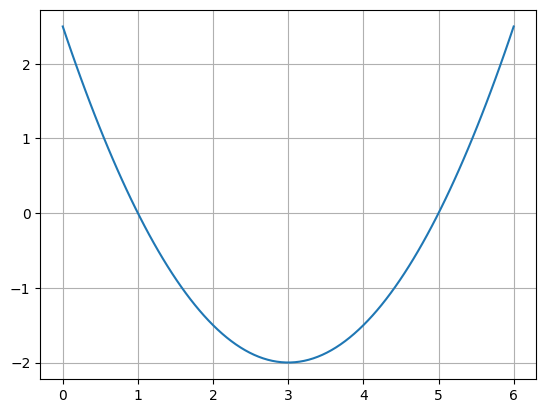

In [7]:
x = np.linspace(0, 6, 100)
plt.plot(x, f(x))
plt.grid()

## Golden-section Search

In [8]:
def gss(f, a, b, n):
    p = phi-1
    d = p * b + (1 - p) * a
    
    for i in range(1, n-1):
        c = p*a + (1-p) * b
        yc, yd = f(c), f(d)
        
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c
            
    if a < b:
        return a, b
    return b, a

In [9]:
gss(f, 1, 5, 15)

(2.993788759969954, 3.001466274871981)

ao comparar com o algoritmo anterior, um pouco mais preciso

## Quadratic fit search

In [10]:
def qfs(f, a, b, c, n):
    ya, yb, yc = f(a), f(b), f(c)
    for i in range(1, n-3):
        x = .5*(ya*(b**2-c**2)+yb*(c**2-a**2)+yc*(a**2-b**2)) / (ya*(b-c) + yb*(c-a) + yc*(a-b))
    yx = f(x)
    if x > b:
        if yx > yb:
            c, yc = x, yx
        else:
            a, ya, b, yb = b, yb, x, yx
    elif x < b:
        if yx > yb:
            a, ya = x, yx
        else:
            c, yc, b, yb = b, yb, x, yx
    
    return a, b, c

In [11]:
qfs(f, 1, 2, 5, 15)

(2, 3.0, 5)

## Shubert-Piyavskii Method

Esse algoritmo converge no mínimo **global** de uma função, desde que seja uniformemente contínua (função de Lipschitz).

In [12]:
from dataclasses import dataclass

In [13]:
# struct para os pontos:
@dataclass
class Pt:
    x: float
    y: float

In [61]:
def get_sp_intersection(A: Pt, B: Pt, l):
    t = ((A.y - B.y) - l*(A.x - B.x)) / 2*l
    return Pt(A.x + t, A.y - t*l)

In [63]:
# funcao principal do metodo shubert-piyavskii
def sp(f, a, b, l, e, tol=0.01):
    '''
    f: funcao
    a, b: intervalo [a, b]
    l: constante Lipschitz
    e: tolerancia
    
    '''
    m = (a+b)/2
    A, M, B = Pt(a, f(a)), Pt(m, f(m)), Pt(b, f(b))
    pts = [A, get_sp_intersection(A, M, l),
           M, get_sp_intersection(M, B, l), B]
    delta = np.inf
    
    while delta > e:
        i = np.argmin([P.y for P in pts])
        P = Pt(pts[i].x, f(pts[i].x))
        delta = P.y - pts[i].y
        
        P_prev = get_sp_intersection(pts[i-1], P, l)
        P_next = get_sp_intersection(P, pts[i+1], l)
        
        pts.pop(i)
        pts.insert(i, P_next)
        pts.insert(i, P)
        pts.insert(i, P_prev)
        
    intervalos = []
    i = 2*(np.argmin([P.y for P in pts[::2]])) - 1
    for j in range(1, len(pts), 2):
        
        if pts[j].y < pts[i].y:
            dy = pts[i].y - pts[j].y
            x_low = max(a, pts[j].x - dy/l)
            x_high = min(b, pts[j].x + dy/l)
            
            if len(intervalos) > 0 and intervalos[-1][1] + tol >= x_low:
                intervalos[-1] = (intervalos[-1][0], x_high)
            else:
                intervalos.append((x_low, x_high))
                
    return pts[i], intervalos

### sen(x)

In [44]:
g = lambda x: np.sin(x)

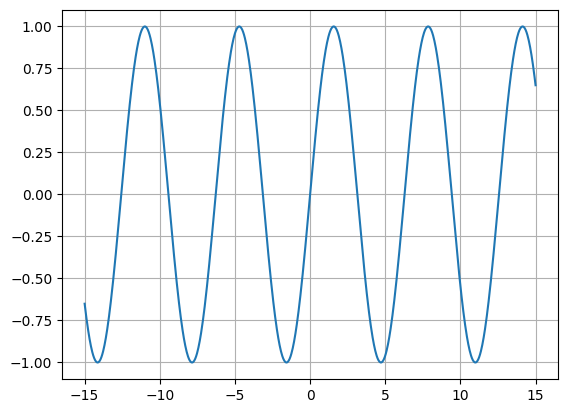

In [94]:
x = np.linspace(-15, 15, 1000)
plt.plot(x, g(x))
plt.grid()

In [86]:
sp(g, -15, 0, 1, 1e-4)[0]

Pt(x=-1.5708985829158353, y=-1.0000722838669551)

In [88]:
sp(g, -15, 0, 1, 1e-4)[1]

[(-14.151208674574244, -14.123480824456161),
 (-7.875434839041983, -7.841625719528951),
 (-1.589974411321341, -1.5821616372288287),
 (-1.5597967739018936, -1.5589034706627218)]

### h(x) = x sen( 10 log(|x|) )

In [132]:
h = lambda x: x*np.sin(10*np.log(abs(x)))

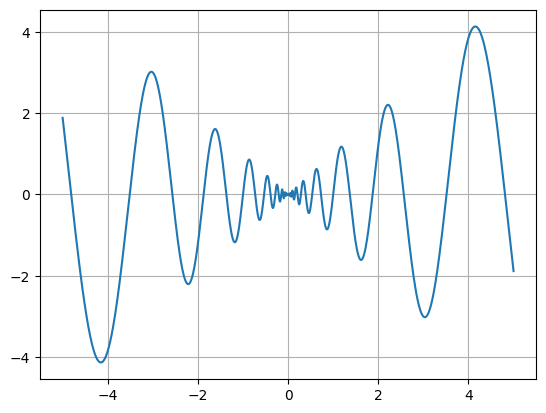

In [135]:
x = np.linspace(-5, 5, 1000)
plt.plot(x, h(x))
plt.grid()

In [146]:
sp(h, 1, 2, 1, 1e-4)[0]

Pt(x=1.843532855854321, y=-0.8435328558543209)